# Urban Sound Multiclass Classifier
### ML1020 - Machine Learning at Scale - 2019

#### Vadim.S. and Murlidhar.L

### Abstract:
The main objective of this project work is the case study of urban sounds audio event identification and classification.
This is a supervised learning where we will be working on an audio event dataset with samples of audio data that belong to specific categories (which are the sources of the sounds).

We will be leveraging concepts from transfer learning and deep learning to build a robust classifier whereby, with any given audio sample belonging to one of our pre-determined categories, we should be able to correctly predict the source of this sound. The dataset we will be using is popularly known as the UrbanSound8K dataset.
UrbanSounds8K dataset has 8,732 labeled audio sound files (the duration of which are usually equal to or greater than 4 seconds) that contain excerpts from common urban sounds.


## Data Analysis

The dataset is downloaded from Kaggle. (to provide the download url)

Let's load the train data and explore available classes and sample distirubtion between the classes. note: the test data is not labled thus it is useless for the training purpose. We have no choice but employ the train dataset to train and validate the model.
The librosa module is an open source Python framework for audio and music analysis.
We will be using this for analyzing as well as extracting features from audio data in subsequent sections.

In [ ]:
# import required lbraries
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display
import soundfile as sf
import glob
import random

# define the path relative to the notebook source
# expected data structure
# -----------------------------------------------
# project root
# src
#   main.ipynb
# data
#   original
#     train
#       samples
#         *.wav
#       train.csv
#     test
#       samples
#         *.wav
#       test.csv
TRAIN_DATA_PATH = "../data/original/train"
TRAIN_FILE = "train.csv"
# Read the train data classification info 
classification = pd.read_csv("{0}/{1}".format(TRAIN_DATA_PATH,TRAIN_FILE),sep = ',')

In [2]:
classification.head(10)

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
5,6,children_playing
6,10,street_music
7,11,drilling
8,12,gun_shot
9,15,dog_bark


In [3]:
classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5435 entries, 0 to 5434
Data columns (total 2 columns):
ID       5435 non-null int64
Class    5435 non-null object
dtypes: int64(1), object(1)
memory usage: 85.0+ KB


Let's examine what classes are available

In [4]:
classes = classification.Class.unique()
classes

array(['siren', 'street_music', 'drilling', 'dog_bark',
       'children_playing', 'gun_shot', 'engine_idling', 'air_conditioner',
       'jackhammer', 'car_horn'], dtype=object)

In [5]:
print("Number of classes: {0}".format(len(classes)))

Number of classes: 10


As per the output above the dataset comprises ten urban sound classes. It is time to take a look at the class population.

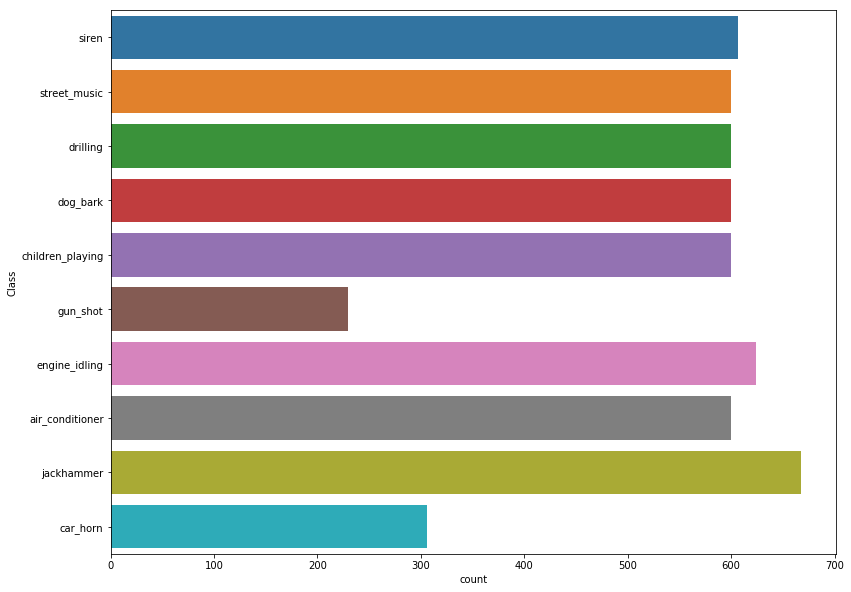

In [19]:
plt.figure(figsize=(13,10))
p = sns.countplot(data=classification,y='Class')

`Gun Shot` and `Car Horn` categories are underpopulated. We could: 

* digitize and upsample these categories
* downsample all categories
* add more labeled observations to the smaller categories
* leave as is hoping that the categories with the smaller population stil have enough to train the network

Let's leave the data intact. If during the training we realize that the scarsly popluated categories are not detected well we will take action

### Basic Data Stats

Let's explore the sound smaples in depth. Knowning the sample duration ,sample, rate, number of channels, ec. will help us to understnad what the data normalization and prepration must be done prior to feeding the data to a model. We start with the extraction of sound characteristics of each sample...  

In [24]:
# grab the full paths of all sample files
paths = glob.glob("{0}/samples/*".format(TRAIN_DATA_PATH))
# create a dataframe
sounds = [] 
for path in paths:
    fn = int(os.path.splitext(os.path.basename(path))[0])
    category = classification[classification.ID == fn]
    audio = sf.SoundFile(path)
    sounds.append((fn , category.Class.values[0], audio.name, audio.channels, audio.samplerate,audio.frames,audio.format,
    round(audio.frames/audio.samplerate,1),audio.subtype))
df = pd.DataFrame(sounds,columns=['ID','Class','Path','Channels','SampleRate','Frames','Format','Length','SubType'])
df.head(20)

,ID,Class,Path,Channels,SampleRate,Frames,Format,Length,SubType
0,0,siren,../data/original/train/samples\0.wav,2,44100,176400,WAV,4.0,PCM_16
1,1,street_music,../data/original/train/samples\1.wav,1,48000,192000,WAV,4.0,PCM_16
2,10,street_music,../data/original/train/samples\10.wav,2,44100,176400,WAV,4.0,PCM_16
3,100,air_conditioner,../data/original/train/samples\100.wav,2,44100,176400,WAV,4.0,PCM_16
4,1000,street_music,../data/original/train/samples\1000.wav,2,44100,176400,WAV,4.0,PCM_16
5,1001,air_conditioner,../data/original/train/samples\1001.wav,2,44100,176400,WAV,4.0,PCM_16
6,1003,dog_bark,../data/original/train/samples\1003.wav,2,96000,384000,WAVEX,4.0,PCM_24
7,1004,air_conditioner,../data/original/train/samples\1004.wav,2,44100,176400,WAV,4.0,PCM_16
8,1006,jackhammer,../data/original/train/samples\1006.wav,2,44100,176400,WAV,4.0,PCM_16
9,1007,car_horn,../data/original/train/samples\1007.wav,1,16000,64000,WAV,4.0,PCM_16


#### Sample Rate Distirbution

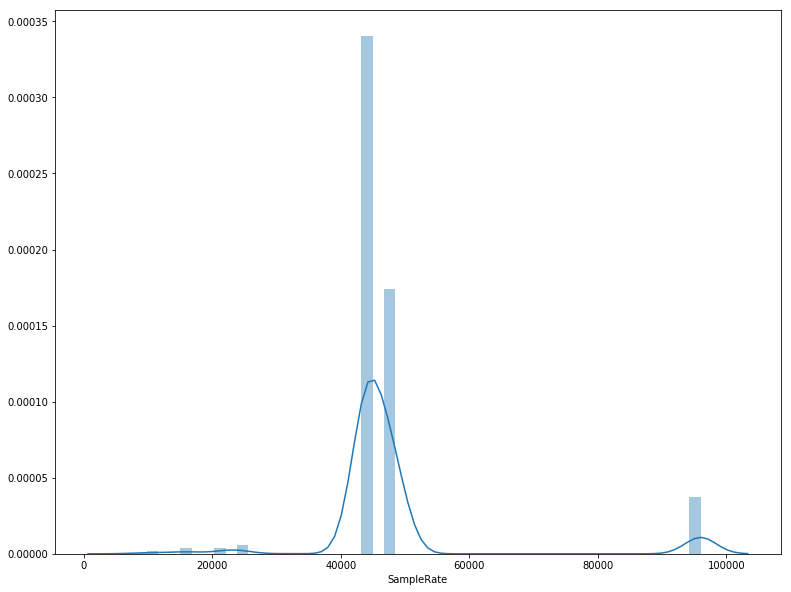

In [25]:
plt.figure(figsize=(13,10))
sns.distplot(df.SampleRate);

Evidently the sample rate of the sound files varies. We would have to resample the original data to bring it to the same standard. Let's caclulate the length of the sounds

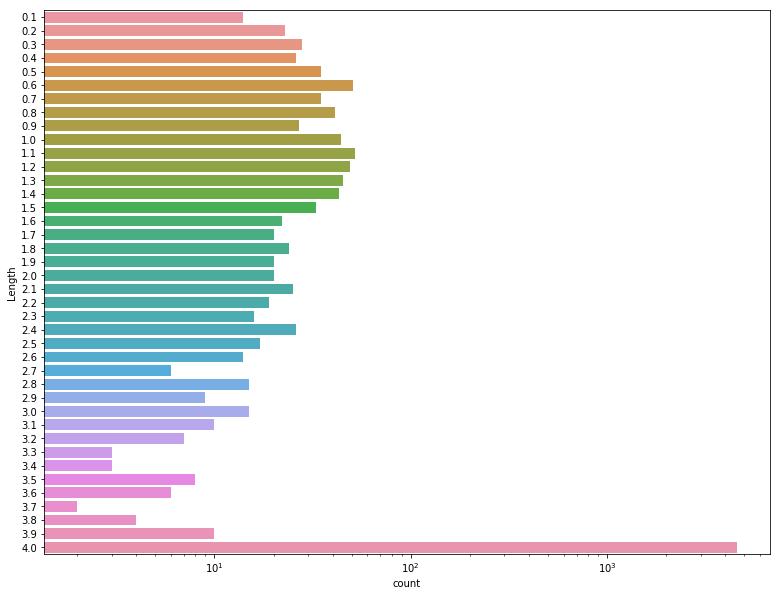

In [26]:
plt.figure(figsize=(13,10))
sns.countplot(y=df.Length, log=True);

Majority of the sound files are 4 second long. But there are some file that are less than a second long. Designing the model we would have to make sure that the input layer is able to deal with the sound samples of various length and a sample rate. We might also filter out the samples that less than 0.5 second long, because mot likely they do not carry to valuable information. Lastly we are going to verify how many channles the recoded audio file have (stereo vs mono)

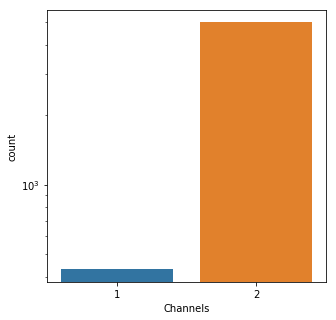

In [27]:
plt.figure(figsize=(5,5))
sns.countplot(x=df.Channels, log=True);

Just a few audo files were recorded in mono. For model training we porbably would need just one channel (TBD)


#### Sound Characteristics of Each Category 

There are ten sound classess. Let's take a sample from each class and review its characteristics.
**Note:** we will be using librosa library to visualize the feautres of the audio sample.

In [28]:
sampleDf=df.groupby('Class',as_index = False,group_keys=False).apply(lambda s: s.sample(1,replace=True))
sampleDf

,ID,Class,Path,Channels,SampleRate,Frames,Format,Length,SubType
1277,2907,air_conditioner,../data/original/train/samples\2907.wav,2,44100,176400,WAV,4.0,PCM_16
251,1386,car_horn,../data/original/train/samples\1386.wav,2,44100,176400,WAV,4.0,PCM_16
1999,3900,children_playing,../data/original/train/samples\3900.wav,1,44100,176400,WAVEX,4.0,PCM_24
1486,3192,dog_bark,../data/original/train/samples\3192.wav,2,44100,51154,WAV,1.2,PCM_16
4850,8024,drilling,../data/original/train/samples\8024.wav,2,44100,56448,WAV,1.3,PCM_16
3681,6371,engine_idling,../data/original/train/samples\6371.wav,2,44100,176400,WAV,4.0,PCM_16
865,2291,gun_shot,../data/original/train/samples\2291.wav,2,44100,73206,WAV,1.7,PCM_16
1765,3577,jackhammer,../data/original/train/samples\3577.wav,2,48000,192000,WAVEX,4.0,PCM_24
656,1982,siren,../data/original/train/samples\1982.wav,2,48000,192000,WAV,4.0,PCM_16
4465,7468,street_music,../data/original/train/samples\7468.wav,2,44100,176400,WAV,4.0,PCM_16


Out of curiosity let's listen a few sounds from our sample collection

**Drilling**

In [45]:
IPython.display.Audio(data=sampleDf[sampleDf.Class == 'drilling'].Path.values[0])

**Children Playing**

In [46]:
IPython.display.Audio(data=sampleDf[sampleDf.Class == 'children_playing'].Path.values[0])

#### Visualize Data

Let's now visualize what these different audio sources look like by plotting their waveforms.
This will be a waveform amplitude plot for each audio sample:

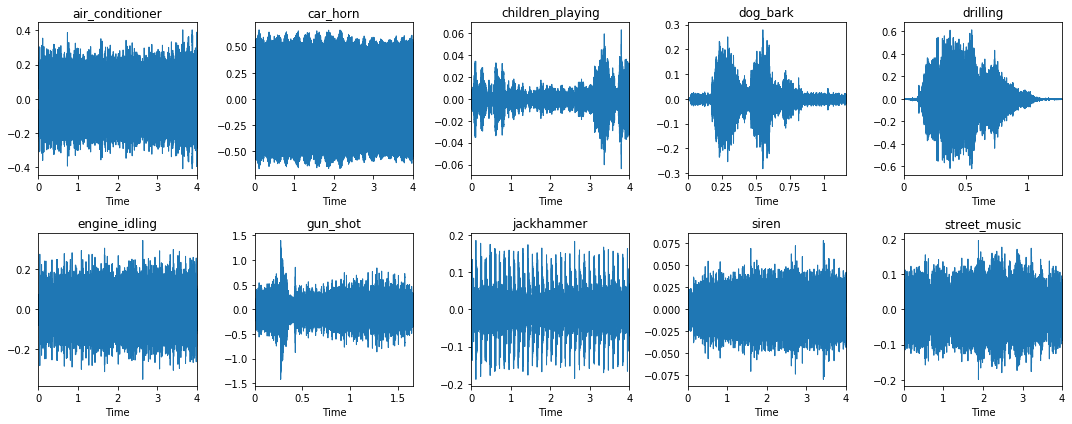

In [34]:
audio=[sf.read(path) for path in sampleDf["Path"]]
i = 0
fig = plt.figure(figsize=(15, 6))
for sample in audio:
    plt.subplot(2, 5, i+1)
    y = librosa.resample(sample[0].T, sample[1], 22050)
    y = librosa.to_mono(y)
    librosa.display.waveplot(y)
    plt.title(sampleDf["Class"].iloc[[i]].values[0])
    i += 1
plt.tight_layout()

The waveform charts rendered above clearly show that each sound class has distinctive characterisitcs, such as rhythm, amplitude, etc.
Though some classes are have more similarities than the other, for example `Air Conditioner` and `Engine Idling` feature rather similar, monotonus sound.
Let's apply another popular technique that exposes the features of the sound even better **mel spectogram**.
The name mel comes from the word melody.
This indicates that the scale is based on pitch comparisons.
The melscale is thus a perceptual scale of pitches that have been judged by listeners to be equal in distance from one another.

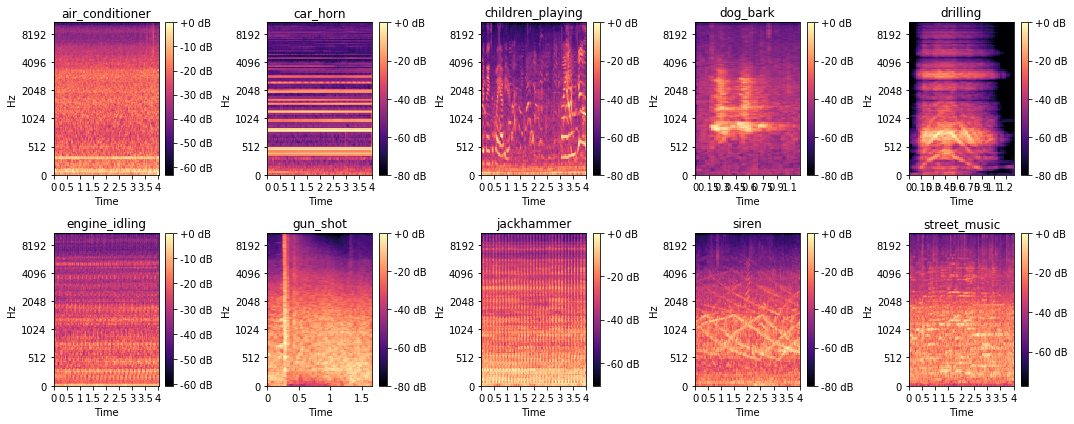

In [47]:
i = 0
fig = plt.figure(figsize=(15, 6))
for sample in audio:
    plt.subplot(2, 5, i+1)
    y = librosa.resample(sample[0].T, sample[1], 22050)
    y = librosa.to_mono(y)
    M = librosa.feature.melspectrogram(y=y)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max), y_axis='mel', x_axis='time')
    plt.title(sampleDf["Class"].iloc[[i]].values[0])
    plt.colorbar(format='%+02.0f dB')
    i += 1
plt.tight_layout()

Evidently the mel spectograms have more features than the amplitude/time waveform presentation. Now the distiction between the `Engine Idling` and `Air Conditioner` is much clearer. Another advantage of such data presentation that it could be fed to the **Convolutional Neural Network**.

## Feature Engineering

To be continued...

#### Conclusion:
TODO

#### References:
Book - Hands on Transfer Learning With Puthon - PACKT Publishing
To Add More references